In [31]:
import pandas as pd

# Load and display the first few rows of each file to understand their structure
file_path_structured = '/content/HealthApp_2k.log_structured.csv'
file_path_templates = '/content/HealthApp_2k.log_templates.csv'

# Loading the structured data file
structured_data = pd.read_csv(file_path_structured)
structured_data_snippet = structured_data.head()

# Loading the template data file
templates_data = pd.read_csv(file_path_templates)
templates_data_snippet = templates_data.head()

structured_data_snippet, templates_data_snippet


(   LineId                   Time                 Component       Pid  \
 0       1  20171223-22:15:29:606                  Step_LSC  30002312   
 1       2  20171223-22:15:29:615                  Step_LSC  30002312   
 2       3  20171223-22:15:29:633  Step_StandReportReceiver  30002312   
 3       4  20171223-22:15:29:635                  Step_LSC  30002312   
 4       5  20171223-22:15:29:635     Step_StandStepCounter  30002312   
 
                                              Content EventId  \
 0                            onStandStepChanged 3579     E42   
 1                      onExtend:1514038530000 14 0 4     E39   
 2  onReceive action: android.intent.action.SCREEN_ON     E41   
 3  processHandleBroadcastAction action:android.in...     E43   
 4                                  flush sensor data     E12   
 
                                        EventTemplate  
 0                             onStandStepChanged <*>  
 1                           onExtend:<*> <*> <*> <*>  


In [32]:
import re
from datetime import datetime

# Function to extract date and steps from the Content field
def extract_steps(row):
    match = re.search(r'onStandStepChanged (\d+)', row['Content'])
    if match:
        steps = int(match.group(1))
        return steps
    return None

# Function to parse the time and extract date
def parse_date(time_str):
    return datetime.strptime(time_str.split('-')[0], '%Y%m%d')

# Applying the functions to extract steps and date
structured_data['Steps'] = structured_data.apply(extract_steps, axis=1)
structured_data['Date'] = structured_data['Time'].apply(parse_date)

# Filtering out rows where steps are not present
step_data = structured_data.dropna(subset=['Steps'])

# Grouping data by Date to get daily step counts
daily_steps = step_data.groupby('Date')['Steps'].max()

daily_steps.head()


Date
2017-12-23    3786.0
2017-12-24    3786.0
Name: Steps, dtype: float64

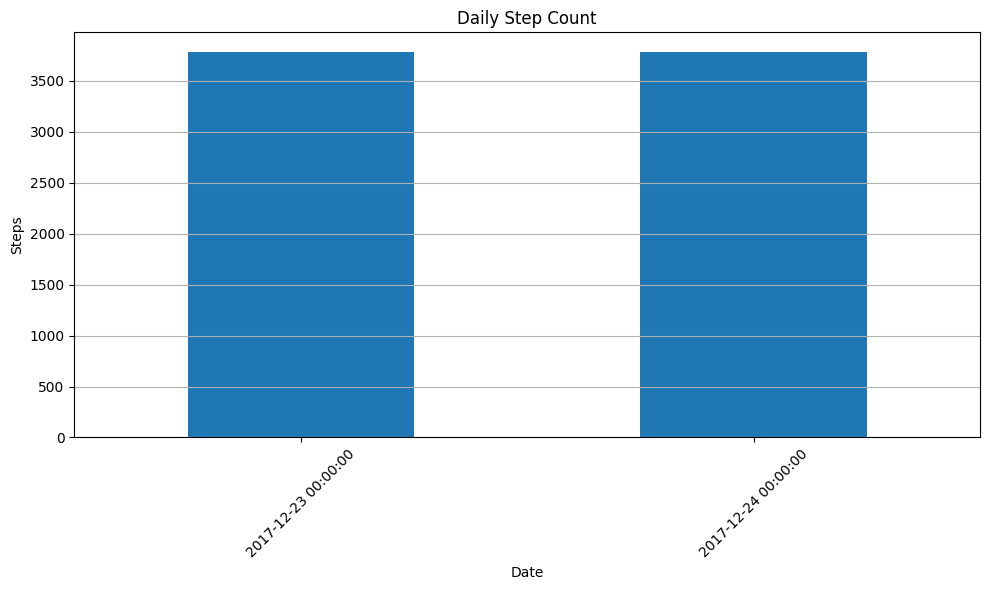

In [33]:
import matplotlib.pyplot as plt

# Plotting the daily step count
plt.figure(figsize=(10, 6))
daily_steps.plot(kind='bar')
plt.title('Daily Step Count')
plt.xlabel('Date')
plt.ylabel('Steps')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()

# Save and display the plot
plt.show()


In [34]:
# Identifying potential columns for workout times or active periods
structured_data[['Time', 'Component', 'Content']].head(10)


,Time,Component,Content
0,20171223-22:15:29:606,Step_LSC,onStandStepChanged 3579
1,20171223-22:15:29:615,Step_LSC,onExtend:1514038530000 14 0 4
2,20171223-22:15:29:633,Step_StandReportReceiver,onReceive action: android.intent.action.SCREEN_ON
3,20171223-22:15:29:635,Step_LSC,processHandleBroadcastAction action:android.in...
4,20171223-22:15:29:635,Step_StandStepCounter,flush sensor data
5,20171223-22:15:29:635,Step_SPUtils,getTodayTotalDetailSteps = 1514038440000##699...
6,20171223-22:15:29:636,Step_SPUtils,setTodayTotalDetailSteps=1514038440000##7007##...
7,20171223-22:15:29:636,Step_LSC,onStandStepChanged 3579
8,20171223-22:15:29:645,Step_ExtSDM,calculateCaloriesWithCache totalCalories=126775
9,20171223-22:15:29:648,Step_ExtSDM,calculateAltitudeWithCache totalAltitude=240


In [35]:
# Calculating step count increments
step_data_sorted = step_data.sort_values(by=['Date', 'Time'])
step_data_sorted['Step_Increment'] = step_data_sorted['Steps'].diff()

# Filtering to keep only positive increments (indicating activity)
active_steps = step_data_sorted[step_data_sorted['Step_Increment'] > 0]

# Extracting time from the 'Time' column for analysis
active_steps['Time'] = active_steps['Time'].apply(lambda x: datetime.strptime(x, "%Y%m%d-%H:%M:%S:%f"))

# Analyzing periods with significant step count increments
significant_activity = active_steps[active_steps['Step_Increment'] >= active_steps['Step_Increment'].quantile(0.75)]

significant_activity.head()


<ipython-input-35-e7a5170c0a6a>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  active_steps['Time'] = active_steps['Time'].apply(lambda x: datetime.strptime(x, "%Y%m%d-%H:%M:%S:%f"))


,LineId,Time,Component,Pid,Content,EventId,EventTemplate,Steps,Date,Step_Increment
27,28,2017-12-23 22:15:30.841,Step_LSC,30002312,onStandStepChanged 3583,E42,onStandStepChanged <*>,3583.0,2017-12-23,2.0
99,100,2017-12-23 22:15:36.356,Step_LSC,30002312,onStandStepChanged 3592,E42,onStandStepChanged <*>,3592.0,2017-12-23,3.0
260,261,2017-12-23 22:15:51.859,Step_LSC,30002312,onStandStepChanged 3616,E42,onStandStepChanged <*>,3616.0,2017-12-23,2.0
274,275,2017-12-23 22:15:53.349,Step_LSC,30002312,onStandStepChanged 3619,E42,onStandStepChanged <*>,3619.0,2017-12-23,2.0
288,289,2017-12-23 22:15:55.349,Step_LSC,30002312,onStandStepChanged 3622,E42,onStandStepChanged <*>,3622.0,2017-12-23,2.0


from matplotlib import pyplot as plt
_df_0['LineId'].plot(kind='hist', bins=20, title='LineId')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['Steps'].plot(kind='hist', bins=20, title='Steps')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['Step_Increment'].plot(kind='hist', bins=20, title='Step_Increment')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_3.groupby('Content').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='LineId', y='Steps', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='Steps', y='Step_Increment', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Time']
  ys = series['Step_Increment']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_6.sort_values('Time', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Content')):
  _plot_series(series, series_name, i)
  fig.legend(title='Content', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Time')
_ = plt.ylabel('Step_Increment')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Time']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Time'}, axis=1)
              .sort_values('Time', ascending=True))
  xs = counted['Time']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_7.sort_values('Time', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Content')):
  _plot_series(series, series_name, i)
  fig.legend(title='Content', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Time')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['LineId']
  ys = series['Step_Increment']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('LineId', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Content')):
  _plot_series(series, series_name, i)
  fig.legend(title='Content', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('LineId')
_ = plt.ylabel('Step_Increment')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['LineId']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'LineId'}, axis=1)
              .sort_values('LineId', ascending=True))
  xs = counted['LineId']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('LineId', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Content')):
  _plot_series(series, series_name, i)
  fig.legend(title='Content', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('LineId')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_10['LineId'].plot(kind='line', figsize=(8, 4), title='LineId')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_11['Steps'].plot(kind='line', figsize=(8, 4), title='Steps')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_12['Step_Increment'].plot(kind='line', figsize=(8, 4), title='Step_Increment')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_13['Content'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_13, x='LineId', y='Content', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_14['Content'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_14, x='Steps', y='Content', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_15['Content'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_15, x='Step_Increment', y='Content', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

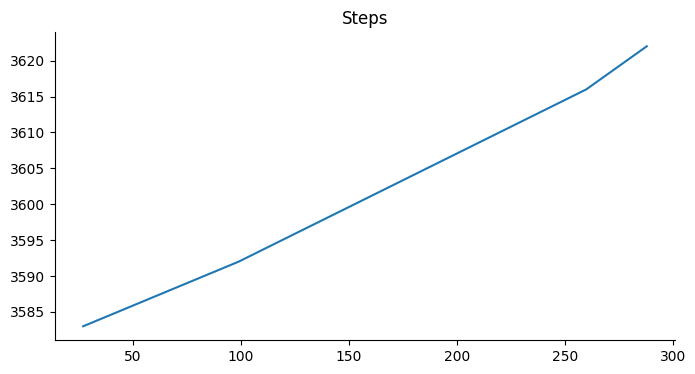

In [39]:
from matplotlib import pyplot as plt
_df_11['Steps'].plot(kind='line', figsize=(8, 4), title='Steps')
plt.gca().spines[['top', 'right']].set_visible(False)

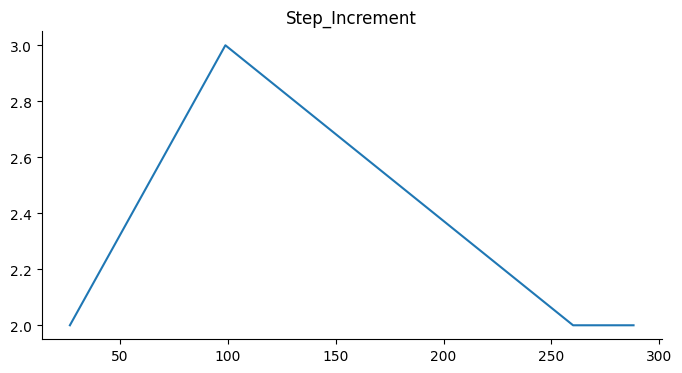

In [38]:
from matplotlib import pyplot as plt
_df_12['Step_Increment'].plot(kind='line', figsize=(8, 4), title='Step_Increment')
plt.gca().spines[['top', 'right']].set_visible(False)

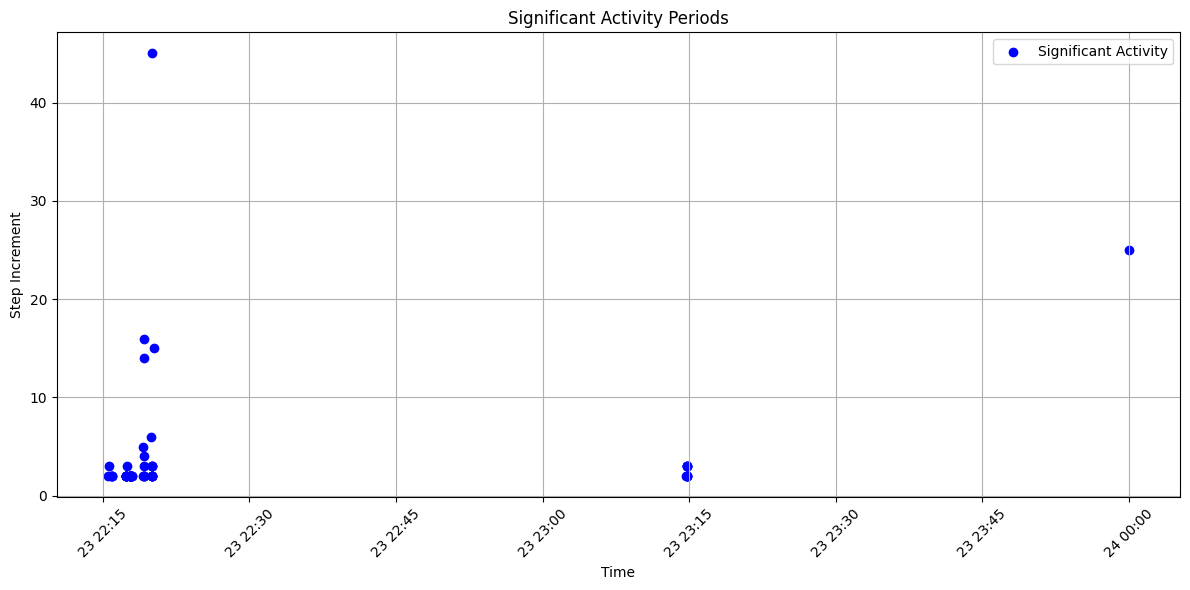

In [36]:
# Plotting the significant activity periods
plt.figure(figsize=(12, 6))
plt.scatter(significant_activity['Time'], significant_activity['Step_Increment'], color='blue', label='Significant Activity')
plt.title('Significant Activity Periods')
plt.xlabel('Time')
plt.ylabel('Step Increment')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()

# Save and display the plot

plt.show()



<ipython-input-37-a552cc485763>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  active_steps['Hour'] = active_steps['Time'].dt.hour


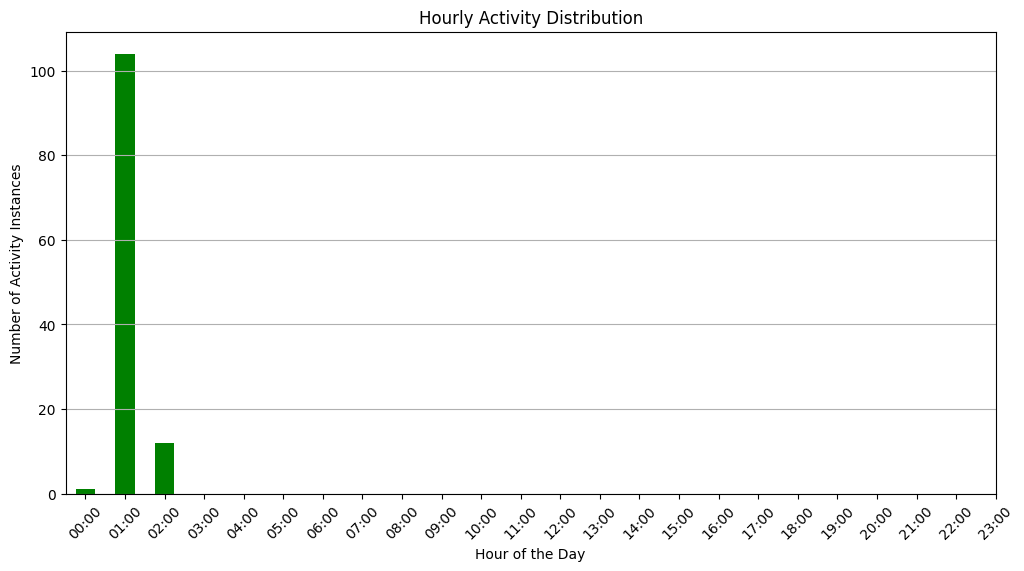

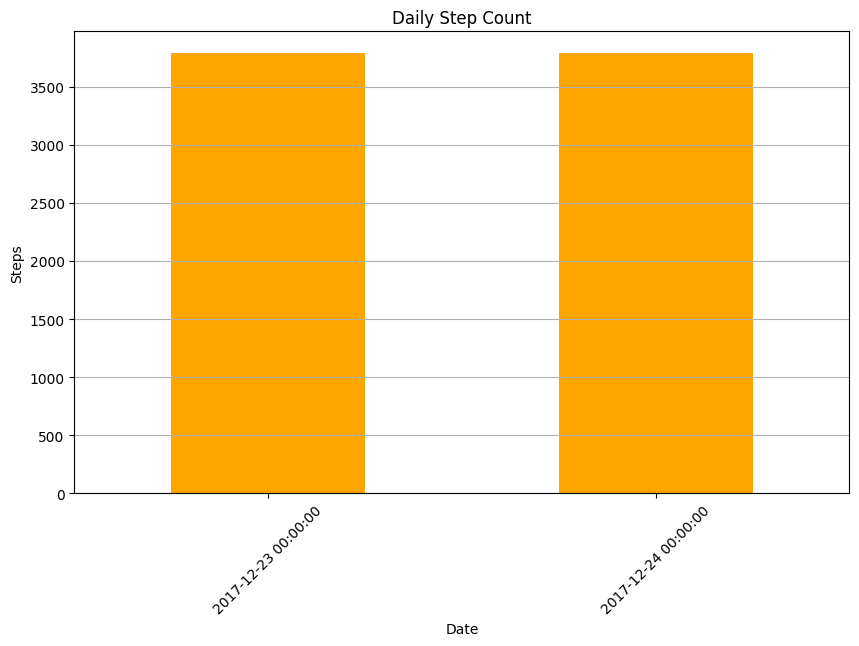

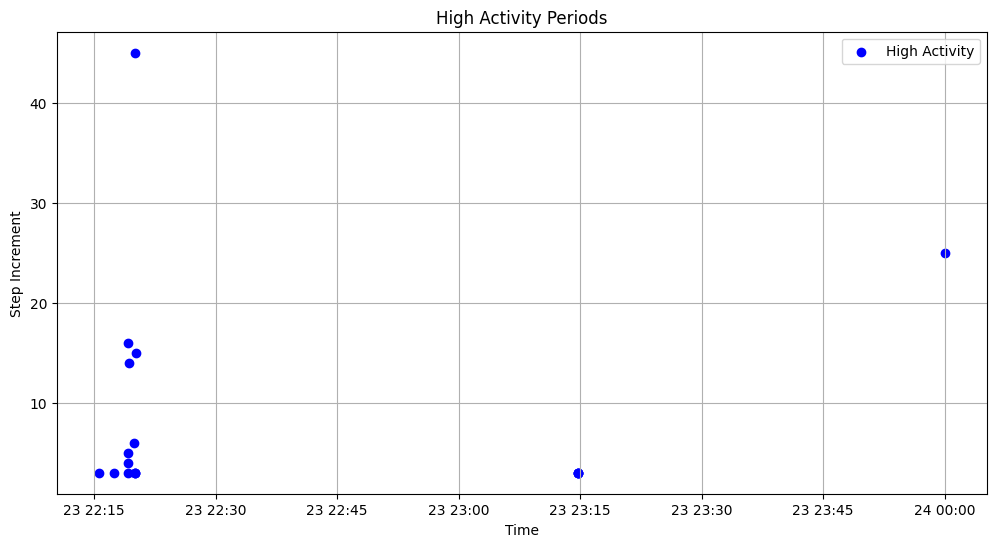

In [37]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'active_steps' DataFrame is correctly prepared
active_steps['Hour'] = active_steps['Time'].dt.hour
hourly_activity = active_steps.groupby('Hour')['Step_Increment'].count()

plt.figure(figsize=(12, 6))
hourly_activity.plot(kind='bar', color='green')
plt.title('Hourly Activity Distribution')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Activity Instances')
plt.xticks(np.arange(24), [f"{h:02d}:00" for h in range(24)], rotation=45)
plt.grid(axis='y')
plt.show()


# Assuming 'step_data' DataFrame is correctly prepared
daily_steps = step_data.groupby('Date')['Steps'].max()

plt.figure(figsize=(10, 6))
daily_steps.plot(kind='bar', color='orange')
plt.title('Daily Step Count')
plt.xlabel('Date')
plt.ylabel('Steps')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()


# Assuming 'active_steps' DataFrame is correctly prepared
high_activity_threshold = active_steps['Step_Increment'].quantile(0.90)
high_activity_periods = active_steps[active_steps['Step_Increment'] >= high_activity_threshold]

plt.figure(figsize=(12, 6))
plt.scatter(high_activity_periods['Time'], high_activity_periods['Step_Increment'], color='blue', label='High Activity')
plt.title('High Activity Periods')
plt.xlabel('Time')
plt.ylabel('Step Increment')
plt.legend()
plt.grid(True)
plt.show()
